# Imports

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import CLIPTokenizer, CLIPModel
from sentence_transformers import SentenceTransformer
import Levenshtein
import numpy as np
import torch

/home/jenifer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
with open('data/pwc/methods.json', 'r') as f:
    methods_data = json.load(f)

In [3]:
methods_data[0]

{'url': 'https://paperswithcode.com/method/sig',
 'name': 'SIG',
 'full_name': 'Sliced Iterative Generator',
 'description': 'The **Sliced Iterative Generator (SIG)** is an iterative generative model that is a Normalizing Flow (NF), but shares the advantages of Generative Adversarial Networks (GANs). The model is based on iterative Optimal Transport of a series of 1D slices through the data space, matching on each slice the probability distribution function (PDF) of the samples to the data. To improve the efficiency, the directions of the orthogonal slices are chosen to maximize the PDF difference between the generated samples and the data using Wasserstein distance at each iteration. A patch based approach is adopted to model the images in a hierarchical way, enabling the model to scale well to high dimensions. \r\n\r\nUnlike GANs, SIG has a NF structure and allows efficient likelihood evaluations that can be used in downstream tasks. While SIG has a deep neural network architecture, 

# Filter data

For the analysis I use the 'name' and 'description' of the mathods that belong to exactly one collection and that collection is not 'General'

In [4]:
flat_data = []
for item in methods_data:
    if len(item["collections"]) == 1:
        area = item["collections"][0]["area"]
        if area != 'General':
            flat_data.append({
                "name": item["name"],
                "description": item["description"],
                "area": area
            })

In [5]:
len(flat_data)

1064

In [6]:
df = pd.DataFrame(flat_data)

This is the final amount of data left after filtering

In [7]:
df['area'].value_counts()

area
Computer Vision                665
Natural Language Processing    119
Graphs                         104
Reinforcement Learning          88
Sequential                      53
Audio                           35
Name: count, dtype: int64

# Define the embeddings

TF-IDF

In [8]:
def compute_tfidf(text_list):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(text_list)
    cosine_sim = cosine_similarity(vectors)
    return cosine_sim

Sentence-BERT embedding

In [9]:
model_bert = SentenceTransformer('all-MiniLM-L6-v2')

def compute_sentence_embeddings(text_list):
    return model_bert.encode(text_list)

/home/jenifer/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


OpenAI CLIP embedding

In [10]:
model_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

def compute_clip_embeddings(text_list):
    inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model_clip.get_text_features(**inputs)
    return outputs.cpu().numpy()

# Calculate the embeddings

In [11]:
names = df['name'].tolist()
descriptions = df['description'].tolist()

In [12]:
names_tfidf = compute_tfidf(names)
descriptions_tfidf = compute_tfidf(descriptions)


In [13]:
sentence_embeddings_names = compute_sentence_embeddings(names)
sentence_embeddings_descriptions = compute_sentence_embeddings(descriptions)

In [14]:
clip_embeddings_names = compute_clip_embeddings(names)
clip_embeddings_descriptions = compute_clip_embeddings(descriptions)

# Reduce dimensionality for the plot

In [15]:
def reduce_dimensionality(embeddings, method='pca'):
    if method == 'pca':
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(embeddings)
    elif method == 'tsne':
        tsne = TSNE(n_components=2, random_state=42)
        reduced = tsne.fit_transform(embeddings)
    return reduced

In [16]:
reduced_names_tfids = reduce_dimensionality(names_tfidf)
reduced_descriptions_tfidf = reduce_dimensionality(descriptions_tfidf)

In [17]:
reduced_embeddings_names = reduce_dimensionality(sentence_embeddings_names)
reduced_embeddings_descriptions = reduce_dimensionality(sentence_embeddings_descriptions)

In [18]:
reduced_clip_names = reduce_dimensionality(clip_embeddings_names)
reduced_clip_descriptions = reduce_dimensionality(clip_embeddings_descriptions)

# Plot

In [19]:
def plot_embeddings(embeddings, color_by, title, color_map):
    plt.figure(figsize=(15, 5))

    # Convert color_by into a categorical type and get unique categories
    categories = pd.Categorical(color_by)
    category_codes = categories.codes
    category_labels = categories.categories
    
    # Create scatter plot
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=category_codes, cmap=color_map)

    plt.title(title)
    
    # Create a custom legend
    unique_categories = np.unique(category_codes)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(code)), markersize=10) 
                       for code in unique_categories]
    plt.legend(legend_elements, category_labels, title="Category", loc="upper right")

    plt.show()

## Plot TF-IDF Embeddings

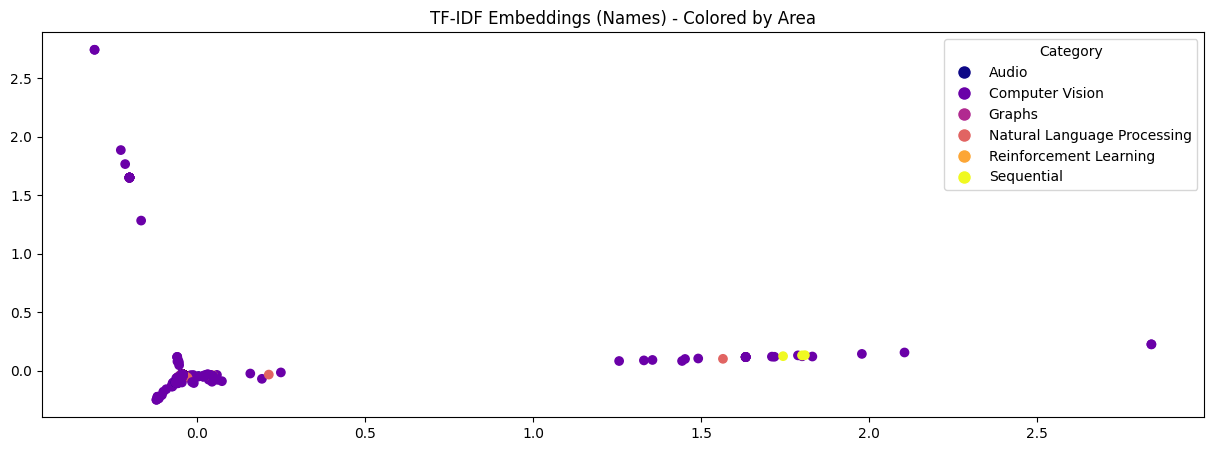

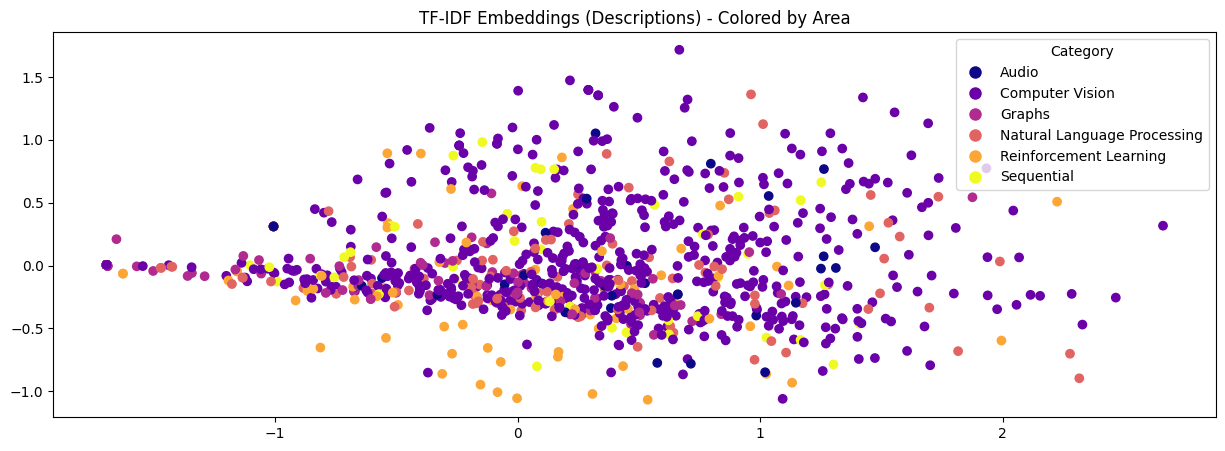

In [20]:
plot_embeddings(reduced_names_tfids, df['area'], 'TF-IDF Embeddings (Names) - Colored by Area', 'plasma')
plot_embeddings(reduced_descriptions_tfidf, df['area'], 'TF-IDF Embeddings (Descriptions) - Colored by Area', 'plasma')

## Plot Sentence-BERT Embeddings 

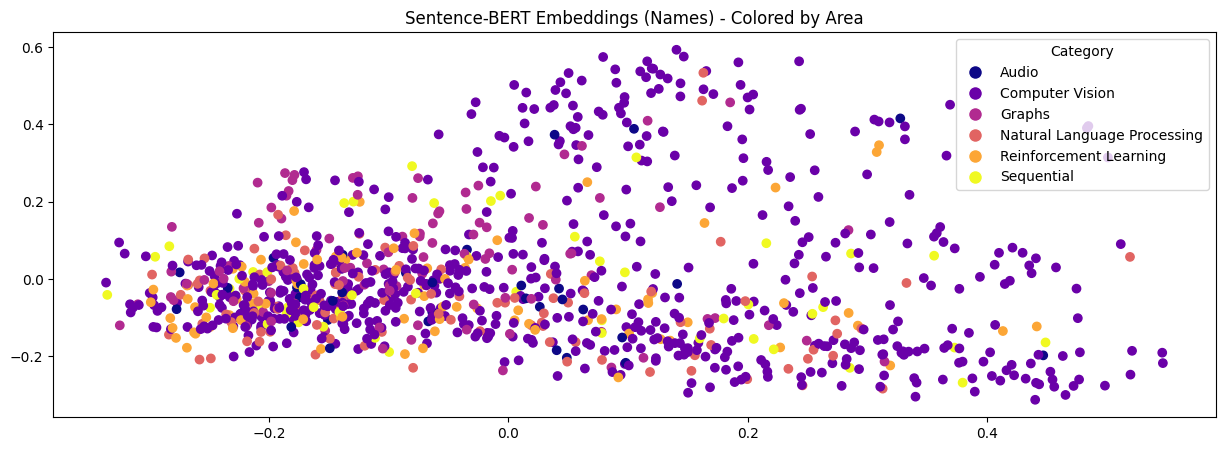

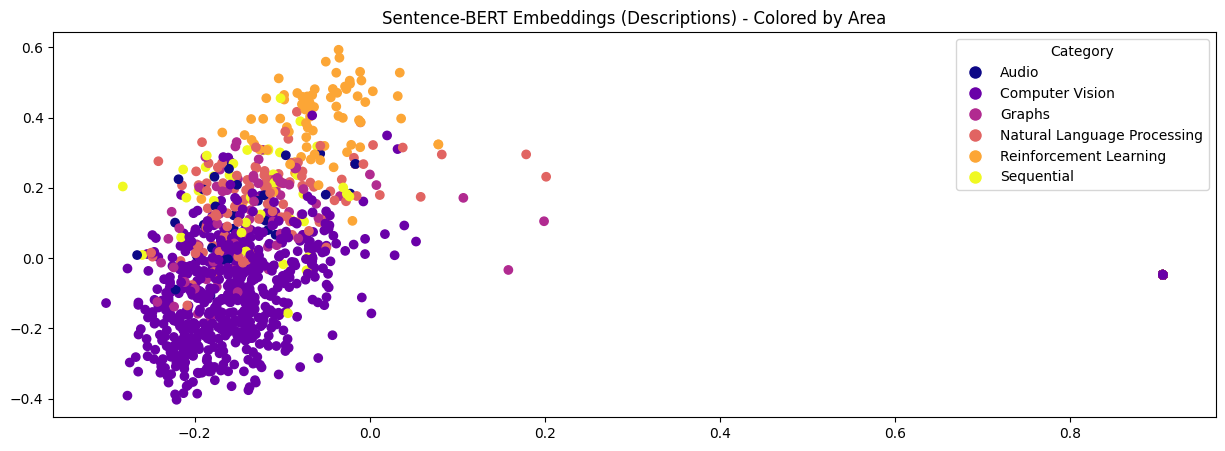

In [21]:
plot_embeddings(reduced_embeddings_names, df['area'], 'Sentence-BERT Embeddings (Names) - Colored by Area', 'plasma')
plot_embeddings(reduced_embeddings_descriptions, df['area'], 'Sentence-BERT Embeddings (Descriptions) - Colored by Area', 'plasma')

## Plot CLIP Embeddings

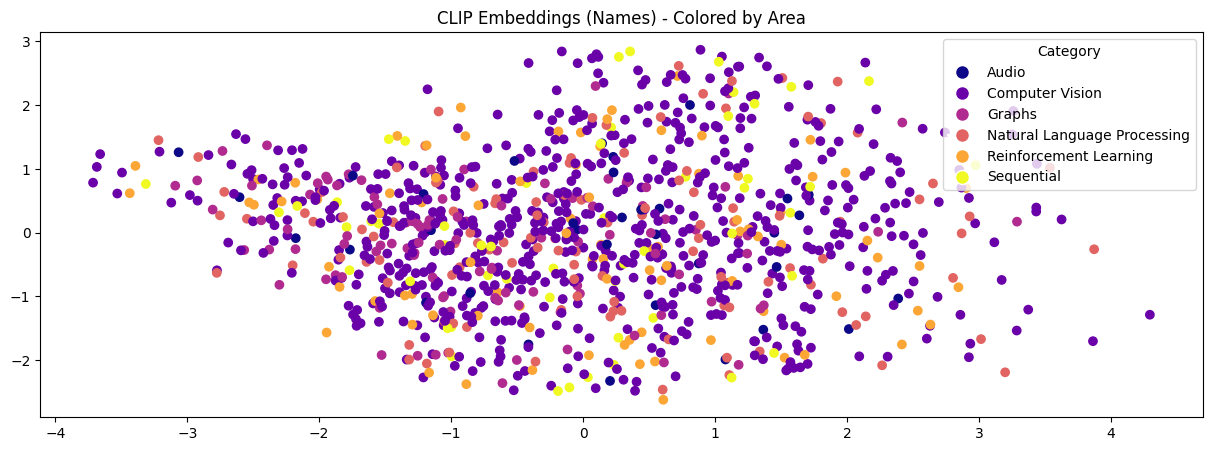

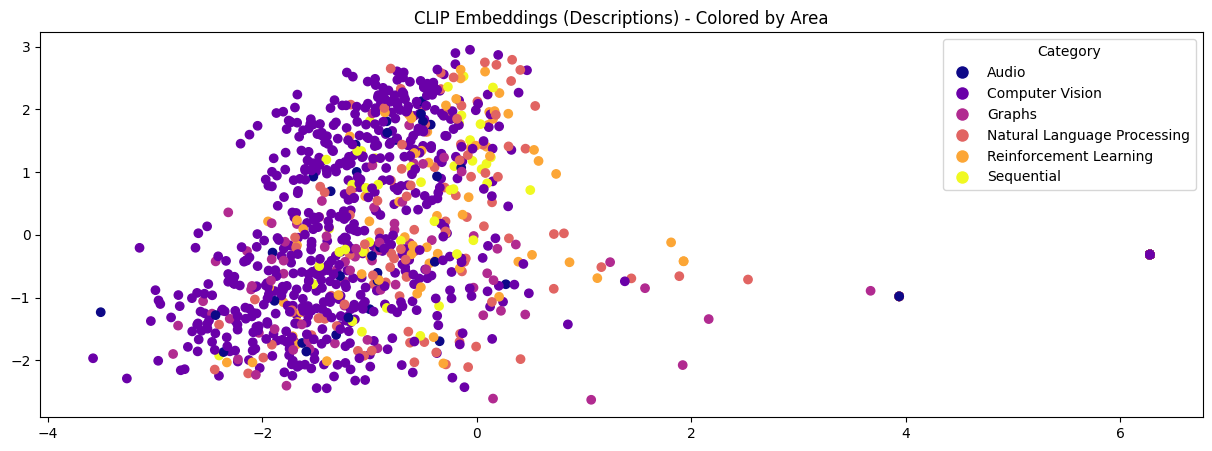

In [22]:
plot_embeddings(reduced_clip_names, df['area'], 'CLIP Embeddings (Names) - Colored by Area', 'plasma')
plot_embeddings(reduced_clip_descriptions, df['area'], 'CLIP Embeddings (Descriptions) - Colored by Area', 'plasma')